## Kaggle Titanic

Check how does scikit learn gridsearch CV work.

In [7]:
%%bash
git branch

* CV_check
  cost1/feat1/wip
  cost1/feat2/wip
  cost1/wip
  feat1/score1/wip
  feat1/wip
  feat2/score1/wip
  feat2/wip
  feat3/wip
  feat4/wip
  feat5/wip
  master


In [8]:
%%bash
git add 'Titanic.ipynb'
git commit -m 'Branched to CV_check'
git push --set-sp

On branch CV_check
Untracked files:
	.ipynb_checkpoints/
	Load_and_Test.txt
	Parameter_Gridsearch_V1.txt
	Train_Test_Concat.txt
	Train_test_concat_for_testingfile.txt
	Xgboost Tutorial.ipynb
	cost1-feat1.sav
	cost1-feat2.sav
	cost1.sav
	feat1-score1.sav
	feat1.sav
	feat2-score1.sav
	feat2.sav
	feat2_test.csv
	feat3.sav
	feat4.sav
	feat5.sav
	gender_submission.csv
	master.sav
	test.csv
	train.csv

nothing added to commit but untracked files present


fatal: The current branch CV_check has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin CV_check



As usual, import all neccasary stuff into the notebook

In [67]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

First, I will start by loading the data in panda dataframe and do some EDA.

In [68]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
#Concate train and test to avoid mismatch features in the testing phase
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
#dataset = pd.get_dummies(dataset)
#train = dataset.copy(dataset[:train_objs_num])
train = dataset[:train_objs_num].copy()
#test = dataset.copy(dataset[train_objs_num:])
test = dataset[train_objs_num:].copy()
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [69]:
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.

In [70]:
X = train.copy()
#X = X.drop('Survived',axis=1)
X = X.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
Y = pd.DataFrame(train['Survived'])

### Label Class Distribution
Lets take a look at class (Survived) distribution, the distribution is slightly skew where more passengers didn't survive.

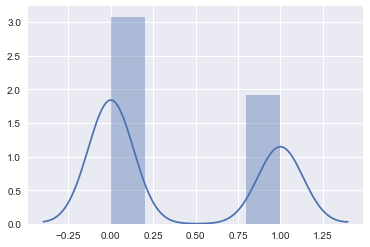

In [71]:
#Y_dist=pd.DataFrame(Y.label.value_counts())
#Y_dist = Y_dist.reset_index()
#Y_dist.columns = ['label','count']
#Y_dist = Y_dist.set_index('label').sort_index().reset_index()
sns.distplot(Y);

Sanitizing data, finding all NaN data in X

In [72]:
X.isnull().any()

Age          True
Cabin        True
Embarked     True
Fare        False
Name        False
Parch       False
Pclass      False
Sex         False
SibSp       False
Survived    False
Ticket      False
dtype: bool

So Age,Cabin and Embarked have NaN value. Drop the missing value rows.

In [73]:
X = X.dropna()
X.isnull().any()

Age         False
Cabin       False
Embarked    False
Fare        False
Name        False
Parch       False
Pclass      False
Sex         False
SibSp       False
Survived    False
Ticket      False
dtype: bool

### Numerical Distribution Plots
Take a look at each numerical atrributes distribution.

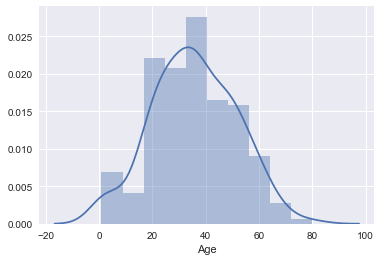

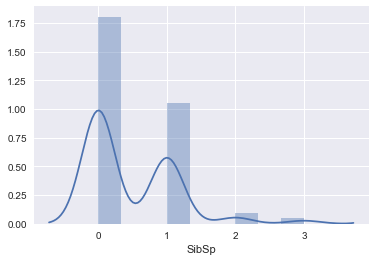

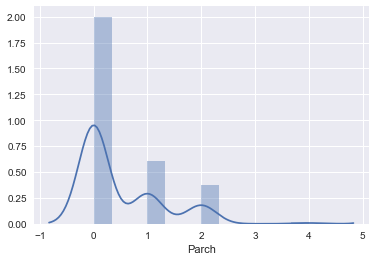

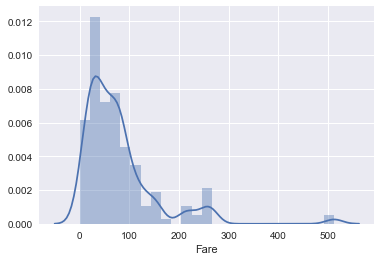

In [74]:
#Divide Numerical and Categorical attributes
#Pclass is actually categorical
num_attri = ['Age','SibSp','Parch','Fare']
cat_attri = [column for column in X if (column not in num_attri and column != 'Survived')]
#print(num_attri)
#print(cat_attri)
#Plot numerical variables
for i,column in enumerate(num_attri):
    #print(column)
    plt.figure(i)
    sns.distplot(X[column])

### Categorical Bar Plots
Now, for categorical attributes, make a bar plot.

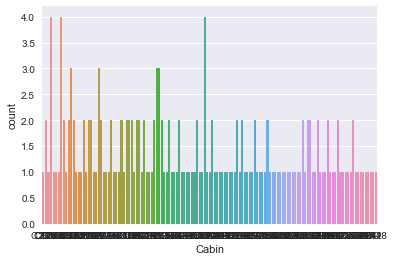

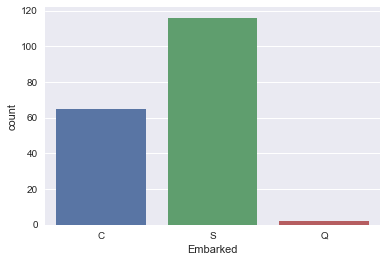

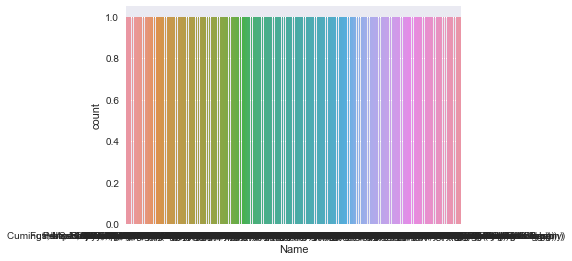

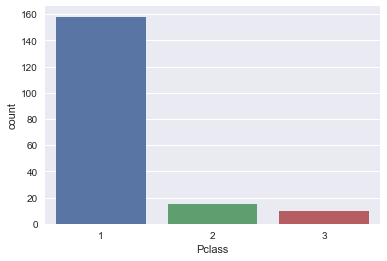

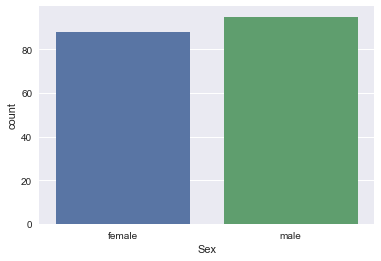

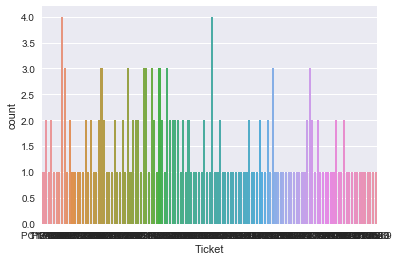

In [75]:
for i,column in enumerate(cat_attri):
    #Lets just keep every categorical attributes for plotting
    plt.figure(i)
    sns.countplot(X[column])

Observation: Majority of Pclass is class 1. Name, as one might expected, is equally distributed (one count for each name). Sex count is equal. Some spikes in Ticket and Cabin. Very small Q (Queenstown) counts for Embarked.

### Pairplot
Make a pairplot for all numerical variables

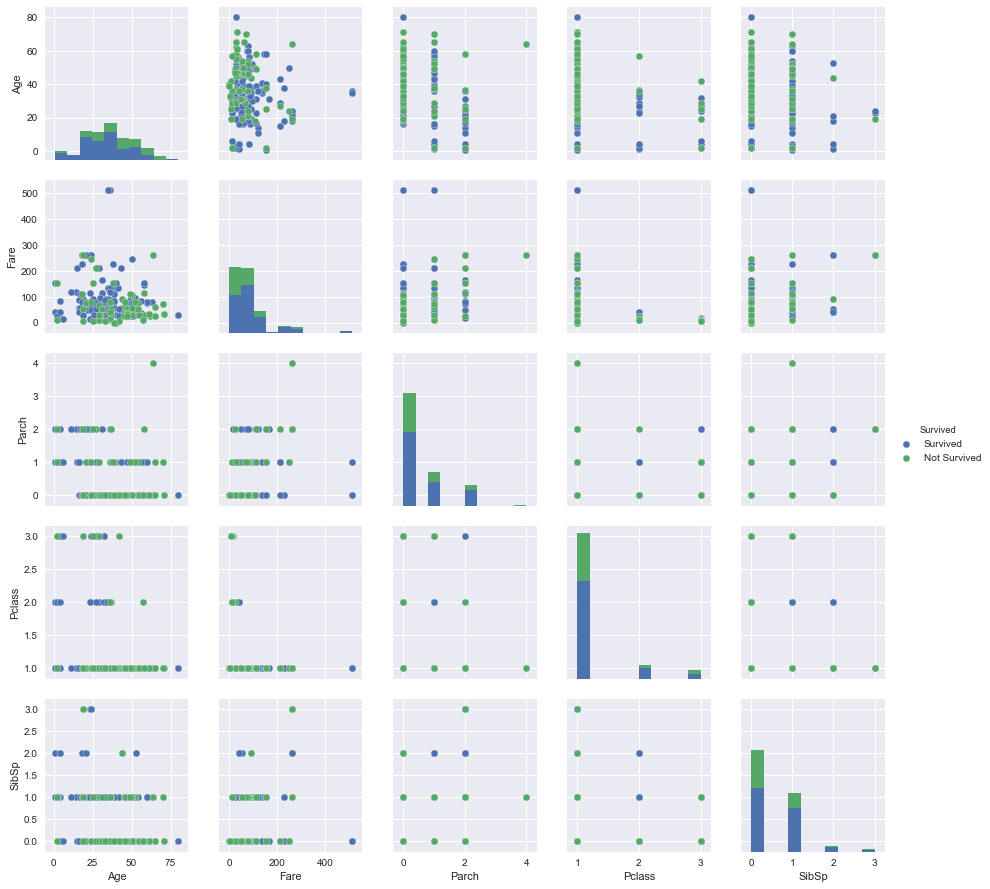

In [76]:
# Make new dataframe for pairplot purpose
X_pairplot = X.copy()
X_pairplot.loc[X_pairplot['Survived']==1,'Survived'] = 'Survived'
X_pairplot.loc[X_pairplot['Survived']==0,'Survived'] = 'Not Survived'

#X_pairplot[Survived=0] = 'Not Survived'

#Add Survived category to numerical attributes for plotting purpose
if 'Survived' not in num_attri:
    num_attri = num_attri + ['Survived']
    
g = sns.pairplot(X_pairplot,hue='Survived')

### Dummy Variables
For starter, create dummy variables for categorical features.

In [77]:
for column in (cat_attri):
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(X[column],prefix=column)
    X.drop(column,axis=1,inplace=True)
    X = X.join(tempDF)

### Feature Evaluation
For starter using random forest to evaluate feature importance.
Code shamelessly brought from:http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [78]:
#Format dataframe for scikit training
y = X['Survived']
X.drop('Survived',axis=1,inplace=True)

Start with numerical feature ranking first

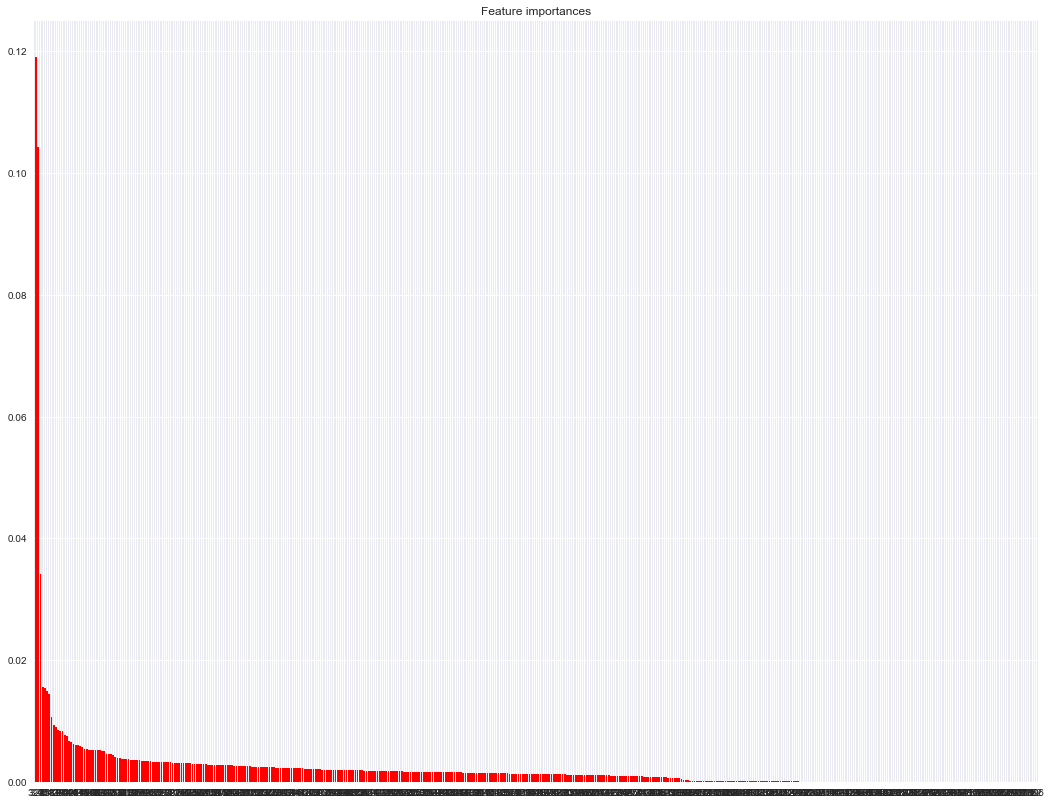

In [79]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                          n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,14))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Model Training
For the sake of early versions use all features for learning. Use 5 fold CV grid search (with 1 fold labelled test set and will not be the part of parameter tuning)

First split into 4:1 train/CV and test dataset

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

clf = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        )
# specify parameters via map
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5,6,7,8],
              'subsample': [0.2,0.4,0.6,0.8],
              'colsample_bytree': [0.6,0.7,0.8]}
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, n_jobs=1, 
                   cv=4, 
                   scoring='roc_auc',
                   verbose=2, refit=False)
clf.fit(X_train,y_train)
best_param_4CV = clf.best_params_

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.3s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.1s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.1s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.3s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsa

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   41.7s finished


Performance on the 4thCV fold

In [82]:
print('Best AUC score:'+str(clf.best_score_))
print('Best Param:' +str(clf.best_params_))

Best AUC score:0.832411789124
Best Param:{'objective': 'binary:logistic', 'subsample': 0.6, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'max_depth': 5}


Now check performance on accuracy basis.

In [83]:
clf2 = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        colsample_bytree = best_param_4CV['colsample_bytree'],
        learning_rate = best_param_4CV['learning_rate'],
        max_depth =  best_param_4CV['max_depth'],
        objective = best_param_4CV['objective'],
        subsample = best_param_4CV['subsample']
        )
clf2.fit(X_train,y_train)
from sklearn.metrics import accuracy_score
print('Accuracy:'+str(accuracy_score(y_train,clf2.predict(X_train))))

Accuracy:0.917808219178


In [86]:
import pickle
# save the model to disk
filename = 'master.sav'
pickle.dump(clf2, open(filename, 'wb'))

Now check performance on the test set.

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print('Test set AUC score:'+str(roc_auc_score(y_test,clf2.predict(X_test))))
print('Test set Accuracy:'+str(accuracy_score(y_test,clf2.predict(X_test))))

Test set AUC score:0.67701863354
Test set Accuracy:0.702702702703
